# Distributed Deep Learning Simulator

### devices
- Processor
    - GPU
    - CPU
    - FPGA
    - TPU
- Switch

### topologies
- Topology
    - 2D Torus
    
### clusters
- Cluster
        
### jobs
- Job (DNN model training task)

### workloads
- Workload (workload for an individual device derived from a Job)
    - DataParallelWorkload
    - ModelParallelWorkload

### managers
- schedulers (which order to schedule queued jobs)
    - Random
    - SRPT (Shortest Remaining Processing Time)
    - FIFO (First In First Out)
    - LRPT (Longest Remaining Processing Time)
- placers (how to place job(s) across device(s)
    - Random
    - IDDFS (Iterative Deepening Depth First Search)
    
### distributions
- Distribution
    - Uniform
    
### simulators
- Simulator

### utils
- seed control

# utils

In [1]:
import numpy as np
import random

def seed_stochastic_modules_globally(default_seed=0, 
                                     numpy_seed=None, 
                                     random_seed=None):
    '''Seeds any stochastic modules so get reproducible results.'''
    if numpy_seed is None:
        numpy_seed = default_seed
    if random_seed is None:
        random_seed = default_seed
    
    np.random.seed(numpy_seed)
    random.seed(random_seed)

# distributions

In [2]:
from abc import ABC, abstractmethod
from typing import Union, Optional
import numpy as np

class Distribution(ABC):

    @abstractmethod
    def sample(self,
               num_samples: int):
        '''Generates data by sampling num_samples from the distribution.'''
        return
    
class Uniform(Distribution):
    def __init__(self,
                 min_val: int,
                 max_val: int,
                 interval: Union[int, float] = 1,
                 decimals: int = 10):
        self.min_val = min_val
        self.max_val = max_val
        self.interval = interval
        self.decimals = decimals

    def sample(self,
               size: Union[int, tuple[int, ...]] = 1,
               replace: bool = True):
        return np.random.choice(
                        np.around(
                            np.arange(self.min_val, self.max_val, self.interval), 
                            decimals=self.decimals), 
                        size=size, replace=replace)

dist = Uniform(min_val=0.1, max_val=0.7, interval=0.01, decimals=2)
print(type(dist))
data = dist.sample(3)
print(data)

issubclass(dist.__class__, Distribution)

<class '__main__.Uniform'>
[0.53 0.32 0.66]


True

# jobs and workloads

https://theaisummer.com/distributed-training/

https://arxiv.org/pdf/1802.09941.pdf

https://dl.acm.org/doi/pdf/10.1145/3452296.3472900


### Data Parallelism

Model is copied onto $N$ devices, and a batch sampled from the training data data is split across these $N$ devices (i.e. each device receives a copy of the model, and different sub-sets of the training data). This is useful for where we want to use larger batch sizes per network update, but where the memory required to hold the batch of data would be too great for e.g. the GPU.

Two types:
- **Synchronous**: When all devices have trained on their sub-set data, aggregate the gradients (e.g. take their mean) across $N$ devices to update network weights. Performs one network update per mini-batch. Can lead to idle machines waiting for other machines to finish, but gradients used to update network have less noise since aggregate across devices.
- **Asynchronous**: Whenever an individual device finishes training on its sub-set, use its gradients to update network weights (i.e. do not aggregate with the gradients calculated by other devices). Performs $N$ network updates per mini-batch. Can avoid idle machines, but gradients used for network updates have higher noise since performing $N$ updates. 


### Model Parallelism

Rather than splitting the data set, model parallelism splits the model onto $N$ devices and copies the batch sampled from the training data to each device. Each device can take a single layer, a set of layers, or more intricate paritions of the model (depending on the model architecture). This is useful for models with a large number of weights (e.g. GPT-2 and GPT-3).

Similar to synchronous data parallelism, model parallelism training times can be slow due to needing to wait for prior operation dependencies (i.e. previous parts of the network) to be completed and synchronised.

Note that model parallelism can be represented as a directed acyclic graph (DAG), where nodes are operations and edges are dependencies. A given operation might be an entire layer, or it could be individual components of the layer (i.e. individual parts of a matrix multiplication). In other words, you can use model parallelism to place layers on different machines, and you can use it to place the same layer across different machines. E.g. both of these were used to fit GPT-3 onto a cluster https://lambdalabs.com/blog/demystifying-gpt-3/

# jobs

Let's first define a generic DNN training job. 

The DNN has some num_weights, where each weight occupies weight_size of memory. To train the DNN, num_epochs training steps will be performed. At each training step (epoch), a batch_size is sampled from a training data set with dataset_size samples. 

In [3]:
class Job:
    def __init__(self,
                 job_id: int,
                 num_layers: int,
                 num_dims_per_layer: int,
                 weight_size: int,
                 num_weights: int,
                 batch_size: int,
                 sample_size: int, # memory per data set sample
                 num_samples: int, # number of samples in data set
                 num_epochs: int,
                 details: dict = {},
                 job_type: str = 'DNN'):
        
        self.job_id = job_id
        self.weight_size = weight_size
        self.num_weights = num_weights
        self.num_layers = num_layers
        self.num_dims_per_layer = num_dims_per_layer
        self.batch_size = batch_size
        self.sample_size = sample_size
        self.num_samples = num_samples
        self.num_epochs = num_epochs
        self.details = details
        self.job_type = job_type
    
    def __str__(self):
        descr = f'Job ID: {self.job_id}'
        descr += f' | Job type: {self.job_type}'
        descr += f' | Per-weight memory: {self.weight_size}'
        descr += f' | # weights: {self.num_weights:.3e}'
        descr += f' | Model memory: {self.get_model_size():.3e}'
        descr += f' | # layers: {self.num_layers}'
        descr += f' | Per-layer # dims: {self.num_dims_per_layer}'
        descr += f' | Batch size: {self.batch_size}'
        descr += f' | Per-sample memory: {self.sample_size}'
        descr += f' | # samples: {self.num_samples:.3e}'
        descr += f' | Data set size: {self.get_dataset_size():.3e}'
        descr += f' | # epochs: {self.num_epochs}'
        return descr
    
    def __eq__(self, other):
        return self.job_id == other.job_id
    
    def get_model_size(self):
        return self.weight_size * self.num_weights

    def get_dataset_size(self):
        return self.sample_size * self.num_samples

To demonstrate the above, can initialise a model roughly similar to the small GPT-3 model (https://lambdalabs.com/blog/demystifying-gpt-3/, see also 'OpenAI GPT-3: Everything You Need to Know' blog post table, original paper: https://arxiv.org/pdf/2005.14165.pdf)

In [4]:
job = Job(job_id=0,
          num_layers=24,
          num_dims_per_layer=768,
          weight_size=4,
          num_weights=int(125e6), # 125M weights
          batch_size=int(0.5e6), # 0.5M batch size
          num_samples=int(300e9), # 300B tokens
          sample_size=150, # 45TB / 300B -> 150 Bytes per sample
          num_epochs=0.6) # use 300B of 410+19+12+55+3=499B tokens -> 0.6 epochs
print(job)

Job ID: 0 | Job type: DNN | Per-weight memory: 4 | # weights: 1.250e+08 | Model memory: 5.000e+08 | # layers: 24 | Per-layer # dims: 768 | Batch size: 500000 | Per-sample memory: 150 | # samples: 3.000e+11 | Data set size: 4.500e+13 | # epochs: 0.6


## Workloads

Want to take a Job and generate some workloads (operations) which we will be able to mount onto physical devices. 

For data parallelism, these workloads will be the entire model.

For model parallelism, these workloads will be individual layers or matrix operations within these layers.

In [5]:
from typing import Union
from abc import ABC, abstractmethod

class Workload(ABC):
    @abstractmethod
    def get_workload_size(self):
        '''Return total memory size occupied by the workload when mounted onto a device.'''
        return
    
    @abstractmethod
    def get_run_time(self, device):
        '''Return total run time of the workload when mounted on the mounted device.'''
        return
    
    def step(self, device, time):
        '''Run the workload for some amount of time on its mounted device.'''
        return
        
class DataParallelWorkload(Workload):
    def __init__(self,
                 workload_id: Union[int, str],
                 job: Job,
                 local_batch_size: int,
                 details: dict = {}):
        self.workload_id = workload_id
        self.job = job
        self.local_batch_size = local_batch_size
        self.details = details
        
        self.time_ran_for = 0
        self.completed = False
        
    def get_workload_size(self):
        return job.get_model_size() + (self.local_batch_size * job.sample_size)
    
    def get_run_time(self, device):
        '''
        Returns the time taken to do a forward and backward pass of the local batch
        through the model to obtain a set of gradients.
        '''
        return self.get_time_per_model_pass(device) * 2
        
    def get_time_per_model_pass(self, device):
        return self.job.num_layers * self.get_time_per_layer_pass(device)
        
    def get_time_per_layer_pass(self, device):
        '''Return time per pass through each layer.
        
        GPU: Each tensor core can do a 4x4 matrix operation in one clock cycle. If we assume the model
        has num_dims_per_layer, and that in each layer a num_dims_per_layer x num_dims_per_layer
        matrix multiplication must be performed, then we can calculate the number of cycles needed
        at each layer and therefore the total number of cycles needed per layer.
        Using as rough guide: https://timdettmers.com/2020/09/07/which-gpu-for-deep-learning/
        
        Args:
            device: Device onto which the workload is mounted.
        '''
        if self.workload_id not in device.mounted_workloads:
            raise Exception(f'Must first mount workload onto device memory.')
            
        if type(device) is GPU:
            # get number of tensor core ops needed for layer matrix operation on the local batch of the workload
            if self.job.num_dims_per_layer % 4 != 0:
                raise Exception(f'Layer dimensions must be divisible by a 4x4 op tensor core.')
            # need to do a batch_size x input_dims x output_dims calculation using 4x4 tensor core(s)
            num_tensor_core_ops = (self.local_batch_size / 4) * (self.job.num_dims_per_layer / 4) * (self.job.num_dims_per_layer / 4)
            batches = math.ceil(num_tensor_core_ops / device.num_tensor_cores)

            # get time to read data from global GPU memory
            time_per_read = self.get_workload_size() / device.memory_bandwidth

            return (batches / device.base_clock_frequency) + (batches * time_per_read)
        
        else:
            raise Exception(f'Unrecognised device type {type(device)}')
            
    def step(self, device, time):
        self.time_ran_for += time
        if self.time_ran_for >= self.get_run_time(device):
            self.completed = True
    
    def __str__(self):
        descr = f'Workload ID: {self.workload_id}'
        descr += f' | Local batch size: {self.local_batch_size}'
        descr += f' | Total workload memory size: {self.get_workload_size():.3e}'
        descr += f' | Parent job ID: {self.job.job_id}'
        return descr
    
class ModelParallelWorkload(Workload):
    def __init__(self,
                 workload_id: int,
                 job: Job):
        self.workload_id = workload_id
        self.job = job

As an example, lets imagine that we are using data parallelism and want to split a job across $N=1,000$ devices.

In [6]:
job = Job(job_id=0,
          num_layers=24,
          num_dims_per_layer=768,
          weight_size=4,
          num_weights=int(125e6),
          batch_size=int(0.5e6),
          num_samples=int(300e9),
          sample_size=150,
          num_epochs=0.6)
print(job)

num_devices = 1000
local_batch_size = int(job.batch_size / num_devices)
workloads = [DataParallelWorkload(workload_id=i, job=job, local_batch_size=local_batch_size) for i in range(num_devices)]
for workload in workloads:
    print(workload)

Job ID: 0 | Job type: DNN | Per-weight memory: 4 | # weights: 1.250e+08 | Model memory: 5.000e+08 | # layers: 24 | Per-layer # dims: 768 | Batch size: 500000 | Per-sample memory: 150 | # samples: 3.000e+11 | Data set size: 4.500e+13 | # epochs: 0.6
Workload ID: 0 | Local batch size: 500 | Total workload memory size: 5.001e+08 | Parent job ID: 0
Workload ID: 1 | Local batch size: 500 | Total workload memory size: 5.001e+08 | Parent job ID: 0
Workload ID: 2 | Local batch size: 500 | Total workload memory size: 5.001e+08 | Parent job ID: 0
Workload ID: 3 | Local batch size: 500 | Total workload memory size: 5.001e+08 | Parent job ID: 0
Workload ID: 4 | Local batch size: 500 | Total workload memory size: 5.001e+08 | Parent job ID: 0
Workload ID: 5 | Local batch size: 500 | Total workload memory size: 5.001e+08 | Parent job ID: 0
Workload ID: 6 | Local batch size: 500 | Total workload memory size: 5.001e+08 | Parent job ID: 0
Workload ID: 7 | Local batch size: 500 | Total workload memory si

# processors

Some notes on processor jargon (https://timdettmers.com/2020/09/07/which-gpu-for-deep-learning/):

- Thread: A virtual component of a processor core, where the physical core is divided into multiple virtual cores
- A 'streaming multiprocessor' (SM) is the GPU equivalent of a CPU core
- GPUs contain Tensor Cores, which are specialised units to handle a $4 \times 4$ matrix operation in a single clock cycle. When ran in parallel, this makes overall matrix operation times very fast.
- Clock cycle: A 'cycle' is an opportunity for a processor to perform a computation
- Clock speed: The rate at which a processor can perform cycles. E.g. 1 GHz clock speed -> can do $10^9$ cycles per second.
- Most operations take more than one cycle to finish, so for one operation to start, must wait for the number of cycles of time it takes for the previous operation to finish (the 'latency' of the operation).
- Example cycling timings/latencies for important operations:
    - Global memory access ($\leq48$ GB): ~200 cycles
    - Shared memory access ($\leq164$ kb per streaming multiprocessor): ~20 cycles
    - Fused multiplicatiuon and addition (FFMA): 4 cycles
    - Tensor Core matrix multiplication: 1 cycle
- Warp: A pack of 32 streaming multiprocessor threads on a GPU. Threads within a warp must wait for each other (i.e. they are synchronous). All memory operations on a GPU are optimised for warps.
    - E.g. loading from global memory happens at a granularity of $32 \times 4 = 128$ bytes (32 floats; 1 float for each thread in the warp).
- Can have up to 32 warps = 1,024 threads in an SM. The physical resources of the SM are divided up between the virtual active warps. Therefore, sometimes want fewer active warps to have more Tensor Core resources available per warp.

In [7]:
from abc import ABC, abstractmethod
import math


class Processor(ABC):
    @abstractmethod
    def mount(self, workload):
        '''Mount a workload onto the device.'''
        return

    @abstractmethod
    def unmount(self, workload):
        '''Unmount a workload from the device.'''
        return
        
    @abstractmethod
    def step(self, time):
        '''Spend some amount of time running the workloads on the device.'''
        return

class GPU(Processor):
    def __init__(self,
                 device_id: int,
                 device_type: str = 'GPU',
                 memory_capacity: int = int(40e9),
                 memory_bandwidth: int = int(1.555e9),
                 num_streaming_multiprocessors: int = 8,
                 num_tensor_cores_per_streaming_multiprocessor: int = 8,
                 base_clock_frequency: int = int(1095e6)):
        '''
        Refer to https://timdettmers.com/2020/09/07/which-gpu-for-deep-learning/ for more details.
        '''
        self.device_id = device_id
        self.device_type = device_type
        
        self.memory_capacity = memory_capacity
        self.memory_occupied = 0
        self.memory_bandwidth = memory_bandwidth
        
        self.num_streaming_multiprocessors = num_streaming_multiprocessors
        self.num_tensor_cores_per_streaming_multiprocessor = num_tensor_cores_per_streaming_multiprocessor
        self.num_tensor_cores = num_streaming_multiprocessors * num_tensor_cores_per_streaming_multiprocessor
        
        self.base_clock_frequency = base_clock_frequency
        
        self.mounted_workloads = {}
        
    def __str__(self):
        return f'{self.device_type}_{self.device_id}'
    
    def mount(self, workload):
        if self.memory_occupied + workload.get_workload_size() > self.memory_capacity:
            raise Exception(f'Trying to allocate {workload.get_workload_size()} of memory but have only {self.memory_capacity - self.memory_occupied} available.')
        self.memory_occupied += workload.get_workload_size()
        self.mounted_workloads[workload.workload_id] = workload
        
    def unmount(self, workload):
        self.memory_occupied -= workload.get_workload_size()
        del self.mounted_workloads[workload.workload_id]
        
    def step(self, time):
        for workload in self.mounted_workloads.values():
            workload.step(self, time)
        

Let's demonstrate the above by mounting a DDL job onto a set of $N=1,000$ devices which will train the DNN via data parallelism.

In [8]:
# initialise the GPU
num_devices = 1000
devices = [GPU(device_id=i, num_streaming_multiprocessors=8) for i in range(num_devices)]

# initialise a job similar to the small GPT-3 model
job = Job(job_id=0,
          num_layers=10,
          num_dims_per_layer=64,
          weight_size=4,
          num_weights=int(10e3),
          batch_size=int(0.1e6),
          num_samples=int(300e6),
          sample_size=150,
          num_epochs=0.6)
print(job)

# split the job into data parallel workloads ready to be mounted onto a cluster
local_batch_size = int(job.batch_size / num_devices)
workloads = [DataParallelWorkload(workload_id=i, job=job, local_batch_size=local_batch_size) for i in range(num_devices)]
    
# mount the workloads onto the devices
for workload, device in zip(workloads, devices):
    device.mount(workload)
    print(f'Device ID {device.device_id} mounted with workload ID {workload.workload_id} -> Run time: {workload.get_run_time(device)} s')

Job ID: 0 | Job type: DNN | Per-weight memory: 4 | # weights: 1.000e+04 | Model memory: 4.000e+04 | # layers: 10 | Per-layer # dims: 64 | Batch size: 100000 | Per-sample memory: 150 | # samples: 3.000e+08 | Data set size: 4.500e+10 | # epochs: 0.6
Device ID 0 mounted with workload ID 0 -> Run time: 0.07074137632324656 s
Device ID 1 mounted with workload ID 1 -> Run time: 0.07074137632324656 s
Device ID 2 mounted with workload ID 2 -> Run time: 0.07074137632324656 s
Device ID 3 mounted with workload ID 3 -> Run time: 0.07074137632324656 s
Device ID 4 mounted with workload ID 4 -> Run time: 0.07074137632324656 s
Device ID 5 mounted with workload ID 5 -> Run time: 0.07074137632324656 s
Device ID 6 mounted with workload ID 6 -> Run time: 0.07074137632324656 s
Device ID 7 mounted with workload ID 7 -> Run time: 0.07074137632324656 s
Device ID 8 mounted with workload ID 8 -> Run time: 0.07074137632324656 s
Device ID 9 mounted with workload ID 9 -> Run time: 0.07074137632324656 s
Device ID 10

Device ID 176 mounted with workload ID 176 -> Run time: 0.07074137632324656 s
Device ID 177 mounted with workload ID 177 -> Run time: 0.07074137632324656 s
Device ID 178 mounted with workload ID 178 -> Run time: 0.07074137632324656 s
Device ID 179 mounted with workload ID 179 -> Run time: 0.07074137632324656 s
Device ID 180 mounted with workload ID 180 -> Run time: 0.07074137632324656 s
Device ID 181 mounted with workload ID 181 -> Run time: 0.07074137632324656 s
Device ID 182 mounted with workload ID 182 -> Run time: 0.07074137632324656 s
Device ID 183 mounted with workload ID 183 -> Run time: 0.07074137632324656 s
Device ID 184 mounted with workload ID 184 -> Run time: 0.07074137632324656 s
Device ID 185 mounted with workload ID 185 -> Run time: 0.07074137632324656 s
Device ID 186 mounted with workload ID 186 -> Run time: 0.07074137632324656 s
Device ID 187 mounted with workload ID 187 -> Run time: 0.07074137632324656 s
Device ID 188 mounted with workload ID 188 -> Run time: 0.070741

Device ID 456 mounted with workload ID 456 -> Run time: 0.07074137632324656 s
Device ID 457 mounted with workload ID 457 -> Run time: 0.07074137632324656 s
Device ID 458 mounted with workload ID 458 -> Run time: 0.07074137632324656 s
Device ID 459 mounted with workload ID 459 -> Run time: 0.07074137632324656 s
Device ID 460 mounted with workload ID 460 -> Run time: 0.07074137632324656 s
Device ID 461 mounted with workload ID 461 -> Run time: 0.07074137632324656 s
Device ID 462 mounted with workload ID 462 -> Run time: 0.07074137632324656 s
Device ID 463 mounted with workload ID 463 -> Run time: 0.07074137632324656 s
Device ID 464 mounted with workload ID 464 -> Run time: 0.07074137632324656 s
Device ID 465 mounted with workload ID 465 -> Run time: 0.07074137632324656 s
Device ID 466 mounted with workload ID 466 -> Run time: 0.07074137632324656 s
Device ID 467 mounted with workload ID 467 -> Run time: 0.07074137632324656 s
Device ID 468 mounted with workload ID 468 -> Run time: 0.070741

Device ID 831 mounted with workload ID 831 -> Run time: 0.07074137632324656 s
Device ID 832 mounted with workload ID 832 -> Run time: 0.07074137632324656 s
Device ID 833 mounted with workload ID 833 -> Run time: 0.07074137632324656 s
Device ID 834 mounted with workload ID 834 -> Run time: 0.07074137632324656 s
Device ID 835 mounted with workload ID 835 -> Run time: 0.07074137632324656 s
Device ID 836 mounted with workload ID 836 -> Run time: 0.07074137632324656 s
Device ID 837 mounted with workload ID 837 -> Run time: 0.07074137632324656 s
Device ID 838 mounted with workload ID 838 -> Run time: 0.07074137632324656 s
Device ID 839 mounted with workload ID 839 -> Run time: 0.07074137632324656 s
Device ID 840 mounted with workload ID 840 -> Run time: 0.07074137632324656 s
Device ID 841 mounted with workload ID 841 -> Run time: 0.07074137632324656 s
Device ID 842 mounted with workload ID 842 -> Run time: 0.07074137632324656 s
Device ID 843 mounted with workload ID 843 -> Run time: 0.070741

# topologies

### 2D Torus
- $x$: Number of dimensions in the $x$ dimension
- $y$: Number of dimensions in the $y$ dimension

- \# nodes = $x \times y$
- \# edges = $2 \times x \times y$
- diameter D = $\frac{x}{2} \times \frac{y}{2}$

['1-1-1', '2-1-1', '3-1-1', '4-1-1']
[('1-1-1', '2-1-1'), ('1-1-1', '4-1-1'), ('2-1-1', '3-1-1'), ('3-1-1', '4-1-1')]


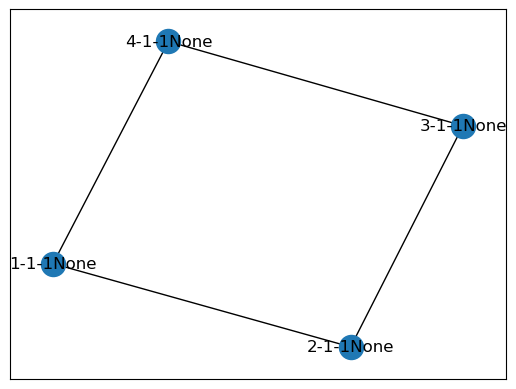

node 1-1-1 device: None
node 2-1-1 device: None
node 3-1-1 device: None
node 4-1-1 device: None


In [9]:
from abc import ABC, abstractmethod
import networkx as nx
from typing import Optional
from collections import defaultdict
import matplotlib.pyplot as plt


class Topology(ABC):
    def __init__(self):
        pass
    
class Node:
    def __init__(self,
                 pos: Optional[dict] = None):
        self.pos = pos
    
    
class Torus(Topology):
    def __init__(self,
                 x_dims: int,
                 y_dims: int = 1,
                 z_dims: int = 1,
                 num_channels: int = 1,
                 channel_capacity: int = int(1.25e9)):
        self.x_dims = x_dims
        self.y_dims = y_dims
        self.z_dims = z_dims
        self.num_channels = num_channels
        self.channel_capacity = channel_capacity
        
        self.topology = nx.Graph()
        self._build_topology()
            
    def _build_topology(self):
        # init nodes
        x_dim_to_nodes, y_dim_to_nodes, z_dim_to_nodes = defaultdict(lambda: []), defaultdict(lambda: []), defaultdict(lambda: [])
        for x in range(1, self.x_dims+1):
            for y in range(1, self.y_dims+1):
                for z in range(1, self.z_dims+1):
                    node = f'{x}-{y}-{z}'
                    x_dim_to_nodes[x].append(node)
                    y_dim_to_nodes[y].append(node)
                    z_dim_to_nodes[z].append(node)
                        
        # for each y_dim (row), connect along x-axis
        for y_dim in range(1, self.y_dims+1):
            self._connect_nodes_in_dim(y_dim, y_dim_to_nodes)
            
        if self.y_dims > 1:
            # for each x_dim (col), connect along y-axis
            for x_dim in range(1, self.x_dims+1):
                self._connect_nodes_in_dim(x_dim, x_dim_to_nodes)
                
        if self.z_dims > 1:
            # for each z_dim, connect along x-axis
            for z_dim in range(1, self.z_dims+1):
                self._connect_nodes_in_dim(z_dim, z_dim_to_nodes)
                
        self._init_link_channels()
        
        # initialise node devices as being empty
        for node in self.topology.nodes:
            self.topology.nodes[node]['device'] = None
            
    def _init_link_channels(self):
        '''Initialise link channels where each direction has 50% of total channel capacity.'''
        channel_names = [f'channel_{channel}' for channel in range(self.num_channels)]
        for link in self.topology.edges:
            self.topology.edges[link[0], link[1]][f'{link[0]}_to_{link[1]}'] = {channel: self.channel_capacity/2 for channel in channel_names}
            self.topology.edges[link[1], link[0]][f'{link[1]}_to_{link[0]}'] = {channel: self.channel_capacity/2 for channel in channel_names}
        self.topology.graph['channel_names'] = channel_names
        self.topology.graph['channel_capacity'] = self.channel_capacity
                         
    def _connect_nodes_in_dim(self, dim, dim_to_nodes):
        for idx in range(len(dim_to_nodes[dim][:-1])):
            self.topology.add_edge(dim_to_nodes[dim][idx], dim_to_nodes[dim][idx+1])
        self.topology.add_edge(dim_to_nodes[dim][-1], dim_to_nodes[dim][0])
                
    def render(self, label_node_names=True, label_node_devices=True):
        fig = plt.figure()
        
        pos = nx.spring_layout(self.topology)
        
        node_labels = {}
        for node in self.topology.nodes:
            node_label = ''
            if label_node_names:
                node_label += node
            if label_node_devices:
                if self.topology.nodes[node]['device'] is None:
                    node_label += 'None'
                else:
                    node_label += str(self.topology.nodes[node]['device'])
            node_labels[node] = node_label
        
        nx.draw_networkx_nodes(self.topology,
                               pos,
                               label=node_labels)
        nx.draw_networkx_edges(self.topology,
                               pos)
        
        nx.draw_networkx_labels(self.topology, pos, labels=node_labels)
        
        plt.show()

            
topology = Torus(x_dims=4)
print(topology.topology.nodes)
print(topology.topology.edges)
topology.render()

for node in topology.topology.nodes:
    print(f'node {node} device: {topology.topology.nodes[node]["device"]}')
        
# topology = Torus(x_dims=4, y_dims=4)
# print(topology.topology.nodes)
# topology.render()

Lets make a 2D Torus and populate the Torus with some GPUs with similar specs to NVIDIA A100 GPUs.

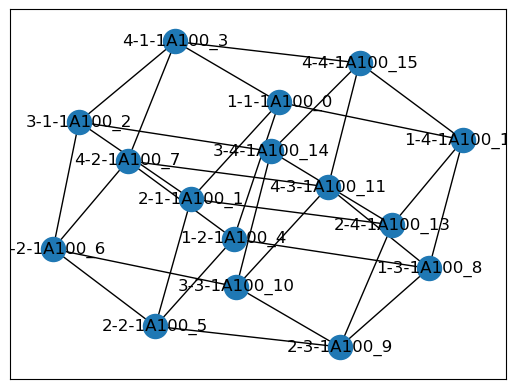

In [10]:
# init topology
topology = Torus(x_dims=4, y_dims=4)

# populate nodes with A100 devices 
for i, node in enumerate(topology.topology.nodes):
    topology.topology.nodes[node]['device'] = GPU(device_id=i, device_type='A100', num_streaming_multiprocessors=8)
    
# display topology
topology.render()

# schedulers

In [11]:
from abc import ABC, abstractmethod

class Scheduler(ABC):
    @abstractmethod
    def prioritise_jobs(self, jobs):
        '''Set order in which a set of jobs should be prioritised.'''
        return
    
class SRPT(Scheduler):
    def __init__(self):
        pass
    
    def prioritise_jobs(self, jobs):
        sizes = np.array([job.get_model_size() + job.get_dataset_size() for job in jobs])
        return np.array(jobs)[np.argsort(sizes)]        

# placers

In [12]:
from abc import ABC, abstractmethod
from collections import defaultdict

class Placer(ABC):
    @abstractmethod
    def __init__(self, 
                 parallelisation: str = 'data_parallelisation'):
        self.parallelisation = parallelisation
    
    @abstractmethod
    def place_job(self, job, cluster):
        '''Place a job in the cluster.'''
        pass
    
class RandomPlacer(Placer):
    def __init__(self,
                 parallelisation: str = 'data_parallelisation'):
        self.parallelisation = parallelisation
        
    def place_job(self, job, cluster):
        '''
        Divides job into parallelisation workloads and attempts to map workloads to cluster nodes.
        If cannot fit all workloads onto cluster, returns None.
        '''
        # consider all cluster nodes as potential workers
        num_workers = len(cluster.topology.topology.nodes)
        
        # create workloads from job
        local_batch_size = int(job.batch_size / num_devices)
        if self.parallelisation == 'data_parallelisation':
            workloads = [DataParallelWorkload(workload_id=i, job=job, local_batch_size=local_batch_size) for i in range(num_workers)]
            
        # map workloads to cluster nodes
        nodes = np.array(copy.deepcopy(cluster.topology.topology.nodes))
        node_to_workloads = defaultdict(lambda: [])
        for workload in workloads:
            np.random.shuffle(nodes)
            for counter, node in enumerate(nodes):
                device = topology.topology.nodes[node]['device']
                if device.memory_occupied + workload.get_workload_size() <= device.memory_capacity:
                    node_to_workloads[node].append(workload)
                else:
                    if counter == len(nodes) - 1:
                        # cannot place workload on any node in cluster
                        return None
                    
        return node_to_workloads

# clusters

In [15]:
from typing import Any, Union
import copy
import math


class Cluster:
    def __init__(self,
                 topology: Topology,
                 scheduler: Any,
                 placer: Any,
                 queue_capacity: int = int(100e12),
                 **kwargs):
        '''
        Args:
            
        '''
        self.topology = topology
        self.scheduler = scheduler
        self.placer = placer
        
        self.queue_capacity = queue_capacity
                
        self.kwargs = self._init_default_kwargs(kwargs)
        
    def _init_default_kwargs(self, kwargs):
        if 'max_simulation_time' not in kwargs:
            kwargs['max_simulation_time'] = 1e12
        if 'simulation_time_resolution' not in kwargs:
            kwargs['simulation_time_resolution'] = 1
        return kwargs
        
    def reset(self, seed: int = 0):
        self.seed = seed
        seed_stochastic_modules_globally(self.seed)
        
        self.wallclock_time, self.time_last_job_arrived = 0, 0
        self.jobs_arrived = {}
        self.jobs_completed = {}
        self.jobs_blocked = {}
        
        self.job_queue = JobQueue(queue_capacity=self.queue_capacity)
        
    def run(self,
            mode: str,
            jobs: list[Job, ...],
            job_interarrival_times: Union[int, float, list] = 1,
            job_sampling_mode: str = 'remove_and_repeat'):
        '''
        Args:
            mode ('time_driven', 'event_driven')
        '''
        self.job_sampler = Sampler(pool=jobs, sampling_mode=job_sampling_mode)
        self.job_interarrival_times = job_interarrival_times
        
        if mode == 'time_driven':
            self.run_time_driven_mode()
        elif mode == 'event_driven':
            self.run_event_driven_mode()
        else:
            raise Exception(f'Unrecognised run mode {mode}')
        
    def run_time_driven_mode(self):
        while not self.check_if_done():
            self.step_cluster()
    
    def run_event_driven_mode(self):
        raise Exception('Not implemented.')
    
    def check_if_done(self):
        pass
    
    def step_job_arrival(self, arrival_time):
        '''Add the next job to the queue.'''
        # get the next job
        job = self.job_sampler.sample()
        job.details['time_arrived'] = arrival_time
        self.time_last_job_arrived = copy.deepcopy(arrival_time)
        
        if self.job_queue.can_fit(job):
            # add job to queue
            self.job_queue.add(job)
        else:
            # no space for job in queue
            self.jobs_blocked[f'{job.job_type}_{job.job_id}'] = job
            
    def step_wallclock_time(self):
        self.prev_wallclock_time = copy.deepcopy(self.wallclock_time)
        self.wallclock_time += self.kwargs['simulation_time_resolution']
        
    def step_job_arrivals(self):
        '''Get next job(s) which arrive during cluster step.'''
        if type(self.job_interarrival_times) is int or type(self.job_interarrival_times) is float:
            # jobs arriving at fixed time interval
            while self.wallclock_time - self.time_last_job_arrived >= self.job_interarrival_times:
                self.step_job_arrival(arrival_time=self.time_last_job_arrived+self.job_interarrival_times)
        elif type(self.job_interarrival_times) is list:
            raise Exception('Not implemented.')
        else:
            raise Exception(f'Unrecognised job_interarrival_times type {type(self.job_interarrival_times)}')
            
    def step_cluster_managers(self):
        '''Schedule order in which to service jobs and place job workloads across cluster.'''
        # use scheduler to assign scheduling priority to 
        prioritised_jobs = self.scheduler.prioritise_jobs(self.job_queue.jobs)
        
        # while have space, divide the jobs into workloads and place the workloads across the cluster
        for job in prioritised_jobs:
            node_to_workloads = placer.place_job(job, self)
            if node_to_workloads is None:
                # could not place job on cluster
                break
            else:
                # mount workloads onto cluster devices
                for node, workloads in node_to_workloads.items():
                    for workload in workloads:
                        self.topology.topology.nodes[node]['device'].mount(workload)
                        
    def step_cluster_processors(self):
        '''Step the cluster devices.'''
        for node in self.topology.topology.nodes:
            self.topology.topology.nodes[node]['device'].step(time=self.kwargs['simulation_time_resolution'])
    
    def step_cluster(self):
        self.step_wallclock_time()
        self.step_job_arrivals()
        self.step_cluster_managers()
        self.step_cluster_processors()
        
        self.register_jobs_status()
        
        

class JobQueue:
    def __init__(self, 
                 queue_capacity: int):
        self.jobs = []
        self.queue_occupancy = 0
        self.queue_capacity = queue_capacity
        
    def __len__(self):
        return len(self.jobs)
        
    def add(self, jobs: Union[list[Job, ...], Job]):
        if type(jobs) is not list:
            jobs = [jobs]
        if self.can_fit(jobs):
            self.jobs.extend(jobs)
        else:
            raise Exception(f'Cannot fit all jobs, only have {self.queue_capacity - self.queue_occupancy} of space remaining.')
    
    def can_fit(self, jobs):
        if type(jobs) is not list:
            jobs = [jobs]
        new_occupancy = copy.deepcopy(self.queue_occupancy)
        for job in jobs:
            new_occupancy += (job.get_model_size() + job.get_dataset_size())
        if new_occupancy <= self.queue_capacity:
            return True
        else:
            return False
    
    def remove(self, jobs: Union[list[Job, ...], Job]):
        if type(jobs) is not list:
            jobs = [jobs]
        for job in jobs:
            self.jobs.remove(job)
            self.queue_occupancy -= (job.get_model_size() + job.get_dataset_size())
        
class Sampler:
    def __init__(self, 
                 pool: list,
                 sampling_mode: str):
        '''
        Args:
            sampling_mode ('replace', 'remove', 'remove_and_repeat')
        '''
        self.original_pool = pool
        self.sample_pool = copy.deepcopy(self.original_pool)
        self.sampling_mode = sampling_mode
    
    def sample(self):
        idx = np.random.randint(low=0, high=len(self.sample_pool))
        datum = self.sample_pool[idx]
        
        if self.sampling_mode == 'replace':
            pass
        elif self.sampling_mode == 'remove':
            self.sample_pool.pop(idx)
        elif self.sampling_mode == 'remove_and_repeat':
            self.sample_pool.pop(idx)
            if len(self.sample_pool) == 0:
                self.sample_pool = copy.deepcopy(self.original_pool)
            
        return datum
        

In [16]:
topology = Torus(x_dims=4, y_dims=4)
for i, node in enumerate(topology.topology.nodes):
    topology.topology.nodes[node]['device'] = GPU(device_id=i, device_type='A100', num_streaming_multiprocessors=8)

scheduler = SRPT()

placer = RandomPlacer()

jobs = [Job(job_id=0,
          num_layers=24,
          num_dims_per_layer=768,
          weight_size=4,
          num_weights=int(1e6),
          batch_size=int(100e3),
          num_samples=int(300e6),
          sample_size=150,
          num_epochs=0.6)
        for job in range(100)]

cluster = Cluster(topology=topology,
                  scheduler=scheduler,
                  placer=placer)

cluster.reset()
cluster.run(mode='time_driven',
            jobs=jobs)



Wallclock time: 0
Wallclock time: 1
Wallclock time: 2
Wallclock time: 3
Wallclock time: 4
Wallclock time: 5
Wallclock time: 6
Wallclock time: 7
Wallclock time: 8
Wallclock time: 9
Wallclock time: 10
Wallclock time: 11
Wallclock time: 12
Wallclock time: 13
Wallclock time: 14
Wallclock time: 15
Wallclock time: 16
Wallclock time: 17
Wallclock time: 18
Wallclock time: 19
Wallclock time: 20
Wallclock time: 21
Wallclock time: 22
Wallclock time: 23
Wallclock time: 24
Wallclock time: 25
Wallclock time: 26
Wallclock time: 27
Wallclock time: 28
Wallclock time: 29
Wallclock time: 30
Wallclock time: 31
Wallclock time: 32
Wallclock time: 33
Wallclock time: 34
Wallclock time: 35
Wallclock time: 36
Wallclock time: 37
Wallclock time: 38
Wallclock time: 39
Wallclock time: 40
Wallclock time: 41
Wallclock time: 42
Wallclock time: 43
Wallclock time: 44
Wallclock time: 45
Wallclock time: 46
Wallclock time: 47
Wallclock time: 48
Wallclock time: 49
Wallclock time: 50
Wallclock time: 51
Wallclock time: 52
Wal

KeyboardInterrupt: 